### Что было опробовано?

    В целом линейные модели показали не такой высокий результат, скорее всего это связано с тем, что распределение цен имеет нелинейный характер. Непараметрические модели в наивной реализации показали результат на 2-4% больше линейных моделей. Существенный прирост качества достигся за счёт того, что данные были обрезаны по 90% квантилю целевой переменной, а также за счёт того, что почти все включая целевую переменную были логарифмированы.

    Разница между разными линейными моделями и различными scaler'ами в качестве невелика 

In [1]:
#import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import folium
import time
from IPython.display import HTML, display
from category_encoders import CountEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, f1_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('AB_NYC_2019.csv')
data.drop(columns=['id', 'name', 'host_id', 'host_name', 'last_review'], axis=1, inplace=True)
print(data['neighbourhood_group'].unique())
print(data['room_type'].unique())

['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
['Private room' 'Entire home/apt' 'Shared room']


In [3]:
data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [4]:
data.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


<AxesSubplot:>

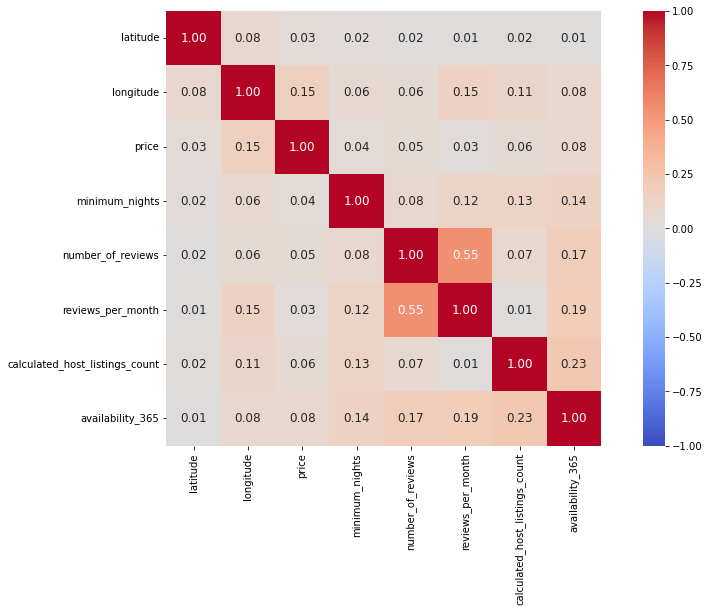

In [5]:
plt.figure(figsize=(15,8))
sns.heatmap(abs(data.corr()), cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, vmin=-1, center=0,\
                        cmap=sns.color_palette('coolwarm',1000))

### Если у этого есть координаты, почему бы это не посмотреть на карте. Посмотрим распределение цен по квантилям.

In [6]:
# price_bins=data.price.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
# data['PriceGroups'] = pd.cut(data['price'], price_bins, \
#                              labels=['0-0.1', '0.1-0.2', '0.2-0.3','0.3-0.4','0.4-0.5',\
#                                      '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1'], 
#                              right=True, include_lowest=True) 

# fig, ax = plt.subplots(figsize=(10,20))


# shape_df = gpd.read_file('nyad.shp').to_crs('EPSG:4326')
# shape_df.plot(ax=ax, color='lightgrey', zorder=1, edgecolor='black', linewidth=1)
# sns.kdeplot(x=data["longitude"], y=data["latitude"], hue=data['PriceGroups'], palette='rocket_r', alpha=0.2, fill=True)

# # условная точка Манхетенна
# sns.scatterplot(x=[-73.993], y=[40.750])

### Самое что ни на есть Манхэттенское расстояние (в градусах, без учёта преград, дорог и т.д.)

 #### Добавим признаки удалённости жилья от данных точек

In [7]:
data['dist_to_manh'] = (abs(data['longitude'] + 73.993) + abs(data['latitude'] - 40.750))
data[['price','dist_to_manh']].corr() # Посмотрим на ёё корреляцию с целевой переменной

,price,dist_to_manh
price,1.000000,-0.183975
dist_to_manh,-0.183975,1.000000


### Мы можем наблюдать множество аномальных цен

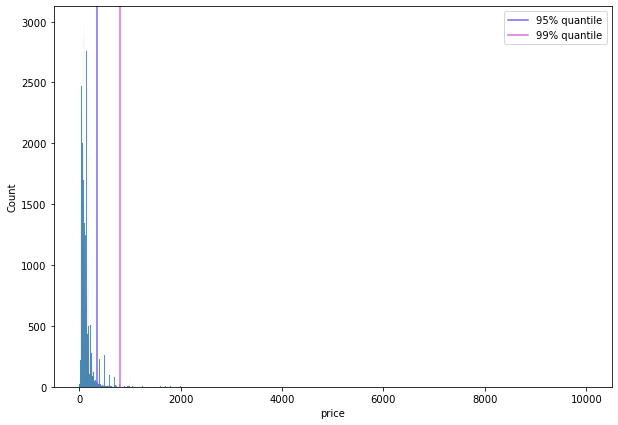

In [8]:
plt.subplots(figsize=(10,7))
sns.histplot(data['price'])
plt.axvline(data.price.quantile(0.95), label='95% quantile', c='mediumslateblue')
plt.axvline(data.price.quantile(0.99), label='99% quantile', c='orchid')
plt.legend()
plt.show()

### Обрежем данные по 90%-ому квантилю целевой переменной

<AxesSubplot:xlabel='price', ylabel='Count'>

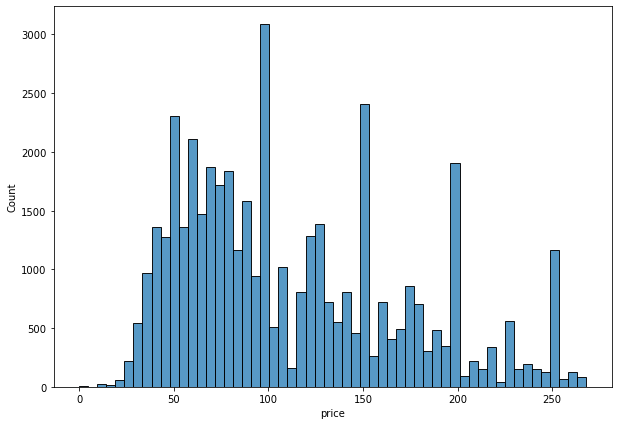

In [9]:
data=data.loc[data.price<data.price.quantile(0.90)]
plt.subplots(figsize=(10,7))
sns.histplot(data['price'])

<AxesSubplot:xlabel='neighbourhood_group', ylabel='price'>

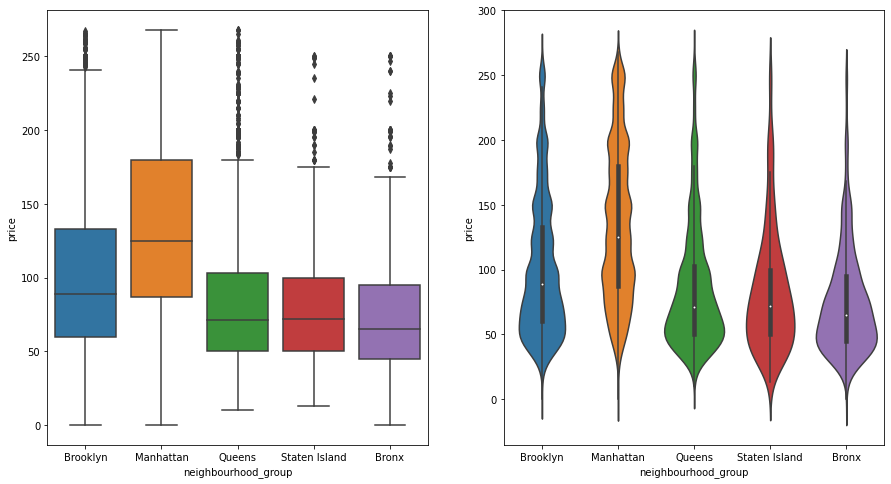

In [10]:
fig, ax = plt.subplots(1,2, figsize=(15, 8))
sns.boxplot(ax=ax[0], data=data, x='neighbourhood_group', y='price')
sns.violinplot(ax=ax[1], data=data, x='neighbourhood_group', y='price')

### Логарифмируем целевую переменную

In [11]:
data['price'] = np.log1p(data['price'])

data['availability_365'] += 0.000000001
data['availability_365'] = np.log1p(data['availability_365'])


data['number_of_reviews'] += 0.000000001
data['number_of_reviews'] = np.log1p(data['number_of_reviews'])

data['calculated_host_listings_count'] += 0.000000001
data['calculated_host_listings_count'] = np.log1p(data['calculated_host_listings_count'])

data['minimum_nights'] += 0.000000001
data['minimum_nights'] = np.log1p(data['minimum_nights'])

data['dist_to_manh'] += 0.000000001
data['dist_to_manh'] = np.log1p(data['dist_to_manh'])

<AxesSubplot:xlabel='price', ylabel='Count'>

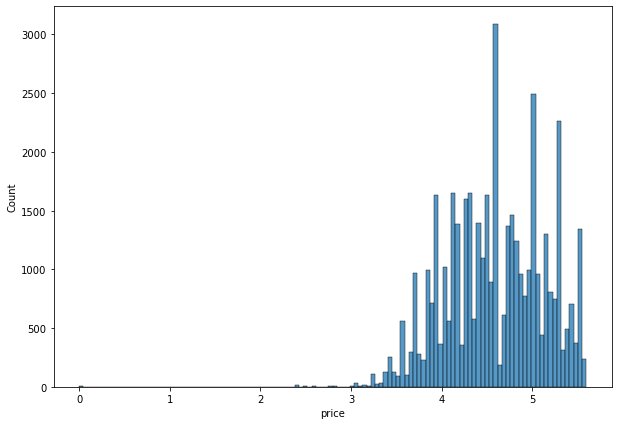

In [12]:
plt.subplots(figsize=(10,7))
sns.histplot(data['price'])

### Перекодируем районы и тип комнат по принципу Ordinary Encode по мере увеличения средней стоимости жилья

In [13]:
data.groupby('neighbourhood').mean()['price'].sort_values()

neighbourhood
Van Nest        3.802393
Bull's Head     3.819775
Tremont         3.840318
Hunts Point     3.863146
Concord         3.879344
                  ...   
West Village    5.139963
NoHo            5.186785
Neponsit        5.303305
Breezy Point    5.360561
Willowbrook     5.521461
Name: price, Length: 219, dtype: float64

In [14]:
data.groupby('room_type').mean()['price'].sort_values()

room_type
Shared room        3.911745
Private room       4.269395
Entire home/apt    4.960745
Name: price, dtype: float64

In [15]:
neighbourhoods = data.groupby('neighbourhood').mean()['price'].sort_values().index.to_list()
room_types = data.groupby('room_type').mean()['price'].sort_values().index.to_list()

encoded_neighbourhoods = {val:i+1 for i, val in enumerate(neighbourhoods)}
encoded_room_types = {val:i+1 for i, val in enumerate(room_types)}

data = data.replace({'neighbourhood':encoded_neighbourhoods})
data = data.replace({'room_type':encoded_room_types})

In [16]:
data = data.drop(['longitude', 'latitude', 'neighbourhood_group', 'reviews_per_month'], axis = 1)

### Повторно оценим матрицу корреляций

In [17]:
def build_heatmap(data, k=2):
    plt.figure(figsize=(10,8))
    corrmat = abs(data.corr())
    cols = corrmat.nlargest(k, 'price')['price'].index.tolist()
    cm = np.corrcoef(data[cols].values.T)
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12},\
                    yticklabels=cols, xticklabels=cols, vmin=-1, center=0,\
                        cmap=sns.color_palette('coolwarm',1000))
    plt.show()

<Figure size 720x576 with 0 Axes>

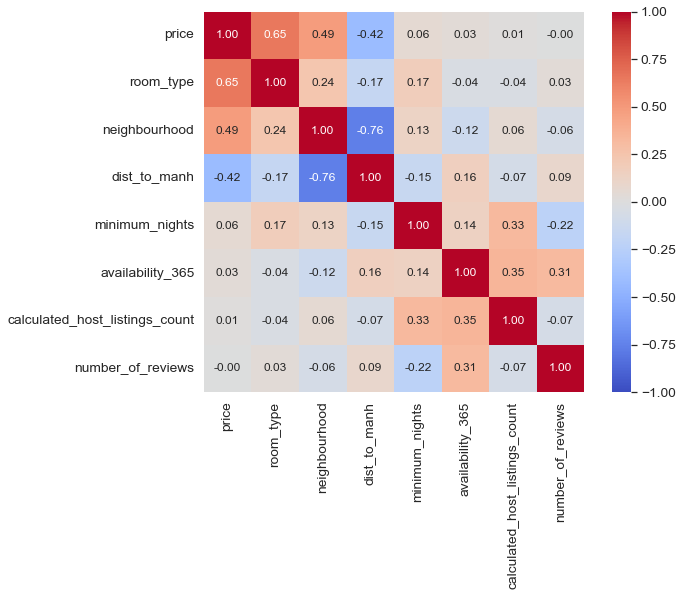

In [18]:
build_heatmap(data, 10)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['price'], axis=1), 
                                                    data['price'], test_size=0.30, 
                                                    random_state=42)

In [20]:
cv = 10
scalers = (RobustScaler(), StandardScaler(), MinMaxScaler())

regressors = (
    RidgeCV(cv=cv, alphas=[0.001,0.01, 0.1, 1, 10]), 
    LassoCV(cv=cv, alphas=[0.001,0.01, 0.1, 1, 10], n_alphas=[100, 200, 300, 400]), 
    ElasticNetCV(cv=cv, alphas=[0.001,0.01, 0.1, 1, 10], n_alphas=[100, 200, 300, 400])
)

for scaler in scalers:
    for regressor in regressors:
        
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        print('R2: ' + str(regressor.score(X_test, y_test)))
        print('RMSE: ' + str(mean_squared_error(y_test, y_pred, squared=False)))
        print('MAE: ' + str(mean_absolute_error(y_test, y_pred)))
        print('Scaler: ' + scaler.__class__.__name__)
        print('Regressor\'s type:' + regressor.__class__.__name__)
        print('==' * 20)

R2: 0.5920655409424496
RMSE: 0.34471705553672877
MAE: 0.2669128324927073
Scaler: RobustScaler
Regressor's type:RidgeCV
R2: 0.5919939217764144
RMSE: 0.34474731439814366
MAE: 0.2670910303768338
Scaler: RobustScaler
Regressor's type:LassoCV
R2: 0.5920494572738535
RMSE: 0.3447238510649191
MAE: 0.2670226368706409
Scaler: RobustScaler
Regressor's type:ElasticNetCV
R2: 0.5920660354977091
RMSE: 0.34471684657952895
MAE: 0.26691740402781494
Scaler: StandardScaler
Regressor's type:RidgeCV
R2: 0.592037546900329
RMSE: 0.3447288832433717
MAE: 0.26701483141197374
Scaler: StandardScaler
Regressor's type:LassoCV
R2: 0.5920609350456922
RMSE: 0.34471900159283086
MAE: 0.2669693845081753
Scaler: StandardScaler
Regressor's type:ElasticNetCV
R2: 0.5920679481776243
RMSE: 0.3447160384416695
MAE: 0.26692729173231255
Scaler: MinMaxScaler
Regressor's type:RidgeCV
R2: 0.5911718958694622
RMSE: 0.34509442764308373
MAE: 0.2677608400447776
Scaler: MinMaxScaler
Regressor's type:LassoCV
R2: 0.5916243812391555
RMSE: 0.34

### Другие модели

In [21]:
reg = GradientBoostingRegressor(max_depth=5, random_state=42)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.6359378151864367

In [22]:
for n in range(1, 21):
    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(X_train, y_train)
    print(knn.score(X_test, y_test))

0.30559004889572206
0.4708049647456435
0.5225835774889229
0.5520516323499857
0.5675388500360765
0.5798203643433031
0.5872724400773979
0.5924546292353283
0.5966041904746076
0.5991234918114103
0.6017326857466411
0.6045140913393375
0.6071309585035969
0.6084815318218001
0.6098950300175375
0.6106260521967279
0.6115355125931843
0.6127322755512827
0.613200242567022
0.6135801555055271
